# data

In [19]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
import calendar

# =========================
# Settings (2021-01-01 to 2021-06-30)
# =========================
START = "2021-01-01"
END   = "2021-06-30"

# Month starts: 2021-01-01 ... 2021-06-01
date_range = pd.date_range(start=START, end=END, freq="MS")

# Store GPT views
gpt_means, gpt_vars = [], []
dates = []            # month label (YYYY-MM-01)
sp500_tickers = None  # ticker universe (fixed from first month)

def _month_end(dt: pd.Timestamp) -> str:
    last_day = calendar.monthrange(dt.year, dt.month)[1]
    return dt.replace(day=last_day).strftime("%Y-%m-%d")

for current_date in date_range:
    start_date = current_date.strftime("%Y-%m-%d")
    end_date = _month_end(current_date)

    fp = Path(f"responses/gpt_{start_date}_{end_date}.json")
    if not fp.exists():
        raise FileNotFoundError(f"Missing GPT responses file: {fp}")

    gpt_dict = json.load(open(fp, "r"))

    # Fix ticker universe on first month (stable ordering)
    if sp500_tickers is None:
        sp500_tickers = list(gpt_dict.keys())

    means_row, vars_row = [], []
    for t in sp500_tickers:
        vals = (gpt_dict.get(t, {}) or {}).get("expected_return", None)
        if isinstance(vals, list) and len(vals) > 0:
            means_row.append(float(np.mean(vals)))
            vars_row.append(float(np.var(vals)))
        else:
            means_row.append(np.nan)
            vars_row.append(np.nan)

    gpt_means.append(means_row)
    gpt_vars.append(vars_row)
    dates.append(start_date)


In [20]:
# Views (means/vars) as DataFrames: rows=tickers, columns=month-start dates
gpt_means_df = pd.DataFrame(np.array(gpt_means), index=dates, columns=sp500_tickers).T
gpt_vars_df  = pd.DataFrame(np.array(gpt_vars),  index=dates, columns=sp500_tickers).T

gpt_means_df.head()


,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01
AAL,0.088776,0.075914,0.050000,-0.058243,0.051600,-0.065000
PNW,-0.033843,-0.070698,0.163306,0.034154,-0.000827,-0.011000
ABT,0.132889,-0.008166,0.000501,0.005758,0.007400,0.005300
AMD,-0.066187,-0.011556,-0.065893,0.039745,0.013800,0.144590
APD,-0.023644,-0.030032,0.081297,0.021152,0.031253,-0.030978


In [21]:
np.array(gpt_means).shape


(6, 413)

In [22]:
import os
import glob
import pandas as pd

PORT_DIR = "responses_portfolios"

def _find_date_col(df: pd.DataFrame) -> str:
    for c in ["date_key", "Date", "date", "ym"]:
        if c in df.columns:
            return c
    # fallback: first unnamed index column
    if len(df.columns) > 0 and str(df.columns[0]).lower().startswith("unnamed"):
        df = df.rename(columns={df.columns[0]: "date_key"})
        return "date_key"
    raise ValueError(f"Aucune colonne de date trouvée. Colonnes: {list(df.columns)}")

def _read_and_standardize(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    date_col = _find_date_col(df)

    # Standardize to 'date_key' as datetime
    if date_col == "ym":
        # 'YYYY-MM' -> month start
        df["date_key"] = pd.to_datetime(df["ym"].astype(str) + "-01", errors="coerce")
    else:
        df["date_key"] = pd.to_datetime(df[date_col], errors="coerce")

    # drop original date cols (except date_key)
    drop_cols = [c for c in ["Date", "date", "ym"] if c in df.columns and c != "date_key"]
    df = df.drop(columns=drop_cols, errors="ignore")

    # keep only rows with date
    df = df.dropna(subset=["date_key"]).copy()
    return df

def combine_monthly_portfolios(
    pattern: str,
    out_path: str,
) -> pd.DataFrame:
    files = sorted(glob.glob(os.path.join(PORT_DIR, pattern)))
    if not files:
        raise FileNotFoundError(f"Aucun fichier trouvé avec le pattern: {PORT_DIR}/{pattern}")

    dfs = []
    for f in files:
        df = _read_and_standardize(f)
        df["source_file"] = os.path.basename(f)  # pratique pour debug
        dfs.append(df)

    out = pd.concat(dfs, ignore_index=True)

    # sort & drop duplicates by date (keep last)
    out = out.sort_values("date_key")
    out = out.drop_duplicates(subset=["date_key"], keep="last").reset_index(drop=True)

    # save combined
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    out.to_csv(out_path, index=False)
    return out

# ---- Build combined baseline files ----
eq_combined = combine_monthly_portfolios(
    pattern="equal_weighted_portfolio*.csv",
    out_path=os.path.join(PORT_DIR, "equal_weighted_portfolio.csv"),
)

opt_combined = combine_monthly_portfolios(
    pattern="optimized_portfolio*.csv",
    out_path=os.path.join(PORT_DIR, "optimized_portfolio.csv"),
)

print("✅ Baselines combinés :")
print(" -", os.path.join(PORT_DIR, "equal_weighted_portfolio.csv"), "(", len(eq_combined), "rows )")
print(" -", os.path.join(PORT_DIR, "optimized_portfolio.csv"), "(", len(opt_combined), "rows )")
display(eq_combined.head())
display(opt_combined.head())


✅ Baselines combinés :
 - responses_portfolios\equal_weighted_portfolio.csv ( 5 rows )
 - responses_portfolios\optimized_portfolio.csv ( 5 rows )


,Portfolio_Return,date_key,source_file
0,0.055666,2021-03-31,equal_weighted_portfolio_2021-02-01_2021-02-28...
1,0.046226,2021-04-30,equal_weighted_portfolio_2021-03-01_2021-03-31...
2,-0.022247,2021-05-31,equal_weighted_portfolio_2021-04-01_2021-04-30...
3,0.004047,2021-06-30,equal_weighted_portfolio_2021-05-01_2021-05-31...
4,0.014215,2021-07-30,equal_weighted_portfolio_2021-06-01_2021-06-30...


,Portfolio_Return,date_key,source_file
0,-0.156229,2021-03-31,optimized_portfolio_2021-02-01_2021-02-28.csv
1,0.124080,2021-04-30,optimized_portfolio_2021-03-01_2021-03-31.csv
2,-0.023304,2021-05-31,optimized_portfolio_2021-04-01_2021-04-30.csv
3,0.060852,2021-06-30,optimized_portfolio_2021-05-01_2021-05-31.csv
4,0.200349,2021-07-30,optimized_portfolio_2021-06-01_2021-06-30.csv


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

"""
Baselines portfolio returns (generated by baselines.py)
Expected files:
  - responses_portfolios/equal_weighted_portfolio.csv
  - responses_portfolios/optimized_portfolio.csv
"""
equal_weighted_portfolio_returns = pd.read_csv('responses_portfolios/equal_weighted_portfolio.csv')
optimized_portfolio_returns      = pd.read_csv('responses_portfolios/optimized_portfolio.csv')

equal_weighted_portfolio_returns.head()


,Portfolio_Return,date_key,source_file
0,0.055666,2021-03-31,equal_weighted_portfolio_2021-02-01_2021-02-28...
1,0.046226,2021-04-30,equal_weighted_portfolio_2021-03-01_2021-03-31...
2,-0.022247,2021-05-31,equal_weighted_portfolio_2021-04-01_2021-04-30...
3,0.004047,2021-06-30,equal_weighted_portfolio_2021-05-01_2021-05-31...
4,0.014215,2021-07-30,equal_weighted_portfolio_2021-06-01_2021-06-30...


In [24]:
equal_weighted_portfolio_returns

,Portfolio_Return,date_key,source_file
0,0.055666,2021-03-31,equal_weighted_portfolio_2021-02-01_2021-02-28...
1,0.046226,2021-04-30,equal_weighted_portfolio_2021-03-01_2021-03-31...
2,-0.022247,2021-05-31,equal_weighted_portfolio_2021-04-01_2021-04-30...
3,0.004047,2021-06-30,equal_weighted_portfolio_2021-05-01_2021-05-31...
4,0.014215,2021-07-30,equal_weighted_portfolio_2021-06-01_2021-06-30...


In [25]:
"""
GPT monthly portfolio weights (Black-Litterman output from evaluate_multiple_updated.py)
"""
import pandas as pd
import numpy as np

tau = 0.025

weights_path = f"results/gpt_black_litterman_weights_tau_{tau}.csv"
gpt_weights_df = pd.read_csv(weights_path)

# detect date column
if "Date" in gpt_weights_df.columns:
    date_col = "Date"
elif "date_key" in gpt_weights_df.columns:
    date_col = "date_key"
else:
    date_col = gpt_weights_df.columns[0]

gpt_weights_df[date_col] = pd.to_datetime(gpt_weights_df[date_col], errors="coerce")
gpt_weights_df = gpt_weights_df.dropna(subset=[date_col]).set_index(date_col).sort_index()

# transpose for plotting: rows=tickers, columns=dates
gpt_results = gpt_weights_df.T
gpt_results.head()


Date,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01
A,9.263838e-17,1.009895e-16,0.000000e+00,0.000000e+00,1.249981e-16,0.000000e+00,0.000000e+00
AAL,5.647128e-18,0.000000e+00,7.664484e-17,1.727739e-16,0.000000e+00,0.000000e+00,0.000000e+00
AAP,1.426539e-16,0.000000e+00,7.064222e-17,0.000000e+00,8.114753e-17,0.000000e+00,3.795327e-17
AAPL,2.883578e-17,0.000000e+00,1.446280e-16,0.000000e+00,2.213297e-17,0.000000e+00,1.208264e-16
ABBV,0.000000e+00,0.000000e+00,5.067088e-17,7.834324e-17,0.000000e+00,1.491752e-16,0.000000e+00


In [26]:
"""
Market caps (no JSON): derive from filtered_sp500_data.csv (market_equity)
We compute market cap per ticker using the last available observation in each month,
then take the market cap as of 2021-06 (end of sample) to sort tickers.
"""
import pandas as pd
import numpy as np

filtered_path = "yfinance/filtered_sp500_data.csv"   # adjust if your path differs
sp = pd.read_csv(filtered_path, low_memory=False)

# Parse date_key from YYYYMMDD in column 'date'
sp["date_key"] = pd.to_datetime(sp["date"].astype("Int64").astype(str), format="%Y%m%d", errors="coerce")

# Month key
sp["ym"] = pd.to_datetime(dict(year=sp["year"], month=sp["month"], day=1), errors="coerce")

# Normalize tickers to match returns/weights convention
sp["tic"] = (sp["tic"].astype(str).str.strip().str.upper().str.replace("-", ".", regex=False))

# Restrict to sample window
start_m = pd.Timestamp("2021-01-01")
end_m   = pd.Timestamp("2021-06-01")
sp = sp[(sp["ym"] >= start_m) & (sp["ym"] <= end_m)].copy()

# Keep last available within each (ticker, month)
sp = sp.sort_values(["tic", "date_key"]).drop_duplicates(subset=["tic", "ym"], keep="last")

# Market cap as-of last month in sample (2021-06)
mc = sp.loc[sp["ym"] == end_m, ["tic", "market_equity"]].dropna()
market_caps_df = mc.groupby("tic")["market_equity"].last().to_frame("Market_Cap")

# Attach market cap to weights table (rows=tickers)
gpt_results["Market_Cap"] = market_caps_df["Market_Cap"]

# Sort by market cap (largest first); keep Market_Cap as last column
gpt_results = gpt_results.sort_values(by="Market_Cap", ascending=False)
gpt_results.head(15)


Date,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,2021-07-01 00:00:00,Market_Cap
AAPL,2.883578e-17,0.000000e+00,1.446280e-16,0.000000e+00,2.213297e-17,0.000000e+00,1.208264e-16,2.079446e+06
MSFT,0.000000e+00,0.000000e+00,0.000000e+00,2.955852e-17,2.552118e-17,0.000000e+00,0.000000e+00,1.880484e+06
AMZN,2.080260e-17,0.000000e+00,0.000000e+00,0.000000e+00,1.364629e-01,1.797362e-17,0.000000e+00,1.625472e+06
GOOG,1.213776e-17,3.628066e-17,8.393156e-18,5.894272e-18,0.000000e+00,0.000000e+00,0.000000e+00,7.088156e+05
TSLA,4.394910e-18,0.000000e+00,8.363983e-17,1.593931e-18,0.000000e+00,0.000000e+00,6.406879e-17,6.022932e+05
JPM,6.285621e-18,0.000000e+00,0.000000e+00,1.342231e-17,0.000000e+00,1.130529e-16,3.400110e-17,4.971755e+05
JNJ,2.984730e-17,0.000000e+00,3.021047e-17,3.664332e-18,0.000000e+00,0.000000e+00,0.000000e+00,4.457023e+05
NVDA,0.000000e+00,0.000000e+00,0.000000e+00,8.430080e-17,1.568168e-17,3.731965e-01,1.145187e-17,4.048130e+05
WMT,0.000000e+00,0.000000e+00,1.751589e-17,0.000000e+00,0.000000e+00,6.082312e-17,0.000000e+00,3.995988e+05
UNH,1.576329e-17,5.675649e-17,5.430817e-17,0.000000e+00,9.757149e-18,1.586462e-16,0.000000e+00,3.887297e+05


In [27]:
market_caps_df.head()


,Market_Cap
tic,
A,4.208794e+04
AAL,1.554712e+04
AAP,1.241441e+04
AAPL,2.079446e+06
ABBV,1.999363e+05


In [28]:
gpt_results.head()


Date,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,2021-07-01 00:00:00,Market_Cap
AAPL,2.883578e-17,0.000000e+00,1.446280e-16,0.000000e+00,2.213297e-17,0.000000e+00,1.208264e-16,2.079446e+06
MSFT,0.000000e+00,0.000000e+00,0.000000e+00,2.955852e-17,2.552118e-17,0.000000e+00,0.000000e+00,1.880484e+06
AMZN,2.080260e-17,0.000000e+00,0.000000e+00,0.000000e+00,1.364629e-01,1.797362e-17,0.000000e+00,1.625472e+06
GOOG,1.213776e-17,3.628066e-17,8.393156e-18,5.894272e-18,0.000000e+00,0.000000e+00,0.000000e+00,7.088156e+05
TSLA,4.394910e-18,0.000000e+00,8.363983e-17,1.593931e-18,0.000000e+00,0.000000e+00,6.406879e-17,6.022932e+05


In [29]:
# (removed old merge step; market caps already attached above)


In [30]:
"""
GPT portfolio returns (generated by calculate_llm_returns.py)
"""
import glob
import pandas as pd

tau = 0.025

candidates = sorted(glob.glob(f"results/gpt_black_litterman_returns_tau_{tau}_2021_*.csv"))
if not candidates:
    candidates = sorted(glob.glob(f"results/gpt_black_litterman_returns_tau_{tau}.csv"))

if not candidates:
    raise FileNotFoundError("Could not find GPT returns CSV in results/. Run calculate_llm_returns.py first.")

gpt_returns_path = candidates[-1]
print("Using:", gpt_returns_path)
gpt_returns = pd.read_csv(gpt_returns_path)
gpt_returns.head()


Using: results\gpt_black_litterman_returns_tau_0.025_2021_01-06.csv


,date_key,Portfolio_Return
0,2021-02-01,0.062654
1,2021-03-01,0.052963
2,2021-04-01,0.040538
3,2021-05-01,0.062464
4,2021-06-01,0.063495


In [31]:
"""
S&P 500 proxy returns (monthly) from yfinance ETF (e.g., SPY):
- Download daily adjusted prices
- Convert to monthly returns (month-end to month-end)
- Keep Jan..Jun 2021 inclusive
"""
import pandas as pd

try:
    import yfinance as yf
except ImportError:
    raise ImportError("yfinance n'est pas installé. Fais: pip install yfinance")

ETF = "SPY"  # alternatives: "IVV", "VOO"
start = "2021-01-01"
end   = "2021-06-30"

# yfinance end is exclusive -> add 1 day
end_excl = (pd.to_datetime(end) + pd.Timedelta(days=1)).strftime("%Y-%m-%d")

px = yf.download(ETF, start=start, end=end_excl, auto_adjust=True, progress=False)

# auto_adjust=True => 'Close' is already adjusted
if "Close" not in px.columns:
    raise ValueError(f"Colonne 'Close' introuvable dans la data yfinance pour {ETF}: {list(px.columns)}")

close = px["Close"].dropna()

# If close is a DataFrame (rare for single ticker), squeeze to Series
if isinstance(close, pd.DataFrame):
    close = close.squeeze("columns")

# Month-end close and monthly returns
m_close = close.resample("ME").last()
m_ret = m_close.pct_change().dropna()

# Build final dataframe
sp500_proxy = pd.DataFrame({
    "date_key": m_ret.index,
    "Portfolio_Return": m_ret.values
})

# Keep months end Jan..Jun 2021
sp500_proxy = sp500_proxy[(sp500_proxy["date_key"] >= "2021-01-31") & (sp500_proxy["date_key"] <= "2021-06-30")].copy()

sp500_proxy


,date_key,Portfolio_Return
0,2021-02-28,0.027805
1,2021-03-31,0.045399
2,2021-04-30,0.052910
3,2021-05-31,0.006566
4,2021-06-30,0.022427


# evlauate

In [ ]:
# sp500_returns
# equal_weighted_portfolio_returns
# optimized_portfolio_returns
# gpt_returns

In [35]:
import numpy as np
import pandas as pd

def _standardize_returns(df: pd.DataFrame, name: str) -> pd.Series:
    """
    Accepts df with 'Portfolio_Return' and one date column among: date_key / Date / ym.
    Returns a Series indexed by datetime at MONTH START (YYYY-MM-01).
    """
    df = df.copy()

    # Detect date column
    if "date_key" in df.columns:
        dt = pd.to_datetime(df["date_key"], errors="coerce")
    elif "Date" in df.columns:
        dt = pd.to_datetime(df["Date"], errors="coerce")
    elif "ym" in df.columns:
        # ym like '2021-02' -> 2021-02-01
        dt = pd.to_datetime(df["ym"].astype(str) + "-01", errors="coerce")
    else:
        raise ValueError(f"{name}: could not find a date column in {list(df.columns)}")

    if "Portfolio_Return" not in df.columns:
        raise ValueError(f"{name}: missing 'Portfolio_Return' column")

    # FORCE month-start to make intersections work across sources
    dt = dt.dt.to_period("M").dt.to_timestamp()

    s = pd.Series(pd.to_numeric(df["Portfolio_Return"], errors="coerce").values, index=dt)
    s = s.dropna()
    s = s[~s.index.duplicated(keep="last")].sort_index()

    # Debug (optional, but useful)
    print(f"{name}: n={len(s)}, [{s.index.min()} .. {s.index.max()}]")
    return s

def _infer_periods_per_year(index: pd.DatetimeIndex) -> int:
    return 12  # ici on sait que c’est mensuel

# Build return series
r_sp500 = _standardize_returns(sp500_proxy, "SP500 proxy")
r_ew    = _standardize_returns(equal_weighted_portfolio_returns, "EW")
r_mvo   = _standardize_returns(optimized_portfolio_returns, "MVO")
r_gpt   = _standardize_returns(gpt_returns, "BLM-GPT")

# Align by common dates
common_idx = r_sp500.index.intersection(r_ew.index).intersection(r_mvo.index).intersection(r_gpt.index)
r_sp500 = r_sp500.loc[common_idx]
r_ew    = r_ew.loc[common_idx]
r_mvo   = r_mvo.loc[common_idx]
r_gpt   = r_gpt.loc[common_idx]

portfolios = {
    "SP500 (cap-wt proxy)": r_sp500,
    "EW": r_ew,
    "MVO": r_mvo,
    "BLM-GPT": r_gpt,
}

ppy = _infer_periods_per_year(common_idx)
rf = 0.02 / ppy  # per-period risk-free rate (2% annual)

stats = {}
for name, returns in portfolios.items():
    returns = returns.astype(float)
    cum = (1 + returns).prod() - 1
    ann_ret = (1 + cum) ** (ppy / max(1, len(returns))) - 1
    ann_vol = returns.std(ddof=1) * np.sqrt(ppy)
    sharpe = ((returns.mean() - rf) / returns.std(ddof=1)) * np.sqrt(ppy) if returns.std(ddof=1) > 0 else np.nan

    wealth = (1 + returns).cumprod()
    peak = wealth.cummax()
    dd = wealth / peak - 1
    mdd = dd.min()

    stats[name] = {
        "Cum. Return": round(float(cum), 4),
        "Ann. Return": round(float(ann_ret), 4),
        "Ann. Vol": round(float(ann_vol), 4),
        "Sharpe": round(float(sharpe), 4),
        "Max Drawdown": round(float(mdd), 4),
    }

stats_df = pd.DataFrame(stats).T
print(f"Periods/year inferred: {ppy}")
stats_df


SP500 proxy: n=5, [2021-02-01 00:00:00 .. 2021-06-01 00:00:00]
EW: n=5, [2021-03-01 00:00:00 .. 2021-07-01 00:00:00]
MVO: n=5, [2021-03-01 00:00:00 .. 2021-07-01 00:00:00]
BLM-GPT: n=6, [2021-02-01 00:00:00 .. 2021-07-01 00:00:00]
Periods/year inferred: 12


,Cum. Return,Ann. Return,Ann. Vol,Sharpe,Max Drawdown
SP500 (cap-wt proxy),0.1328,0.4536,0.0736,4.9156,0.0000
EW,0.0843,0.2747,0.1264,1.8278,-0.0222
MVO,-0.0173,-0.0509,0.4197,-0.0091,-0.0233
BLM-GPT,0.2380,0.8974,0.0369,17.2827,0.0000


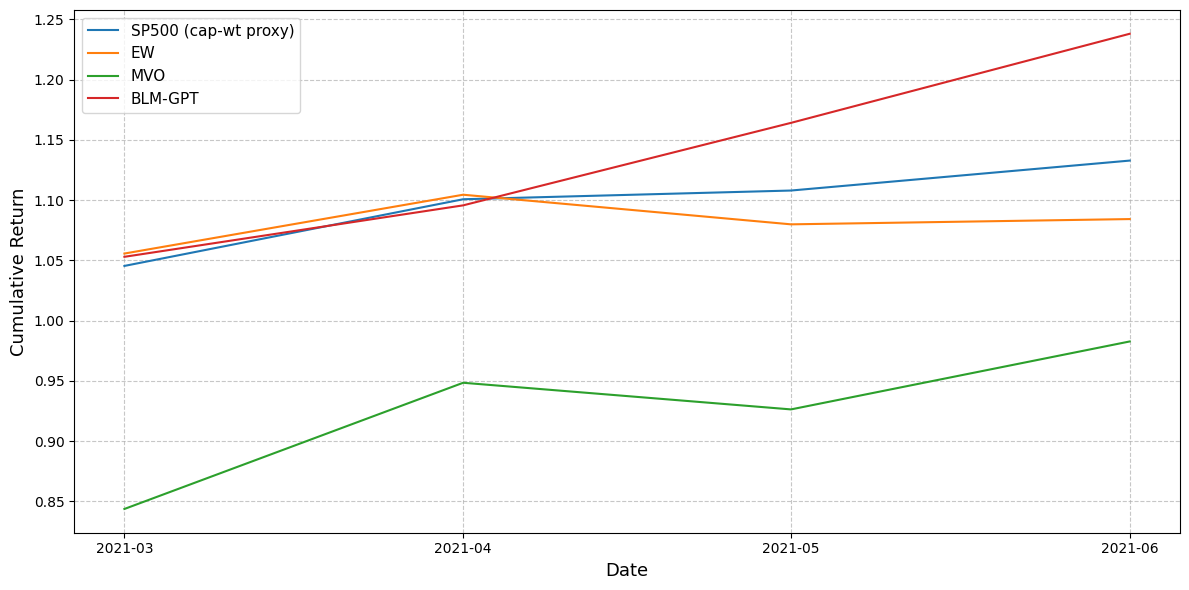

In [36]:
import matplotlib.pyplot as plt
import matplotlib

plt.figure(figsize=(12, 6))

for name, returns in portfolios.items():
    cum = (1 + returns).cumprod()
    plt.plot(cum.index, cum.values, label=name)

plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Date", fontsize=13)
plt.ylabel("Cumulative Return", fontsize=13)
plt.legend(loc="upper left", fontsize=11)

plt.gca().xaxis.set_major_locator(matplotlib.dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))

plt.tight_layout()
plt.savefig("cumulative_returns_2021H1_gpt.pdf")
plt.show()
